# GUIA 5 (DFT)
## Por Facundo L. Sanchez

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy import interpolate
from scipy import integrate
%matplotlib inline
from __future__ import division

# Hamiltoniano matricial con potencial coulombiano

In [3]:
def H_matriz(h,N,Z,l):
    r = np.arange(h,h*(N+1),h)
    
    offDiag_der2 = np.ones(len(r)-1)
    diag_cent = l*(l+1)/(2*r**2)
    T_matriz = (np.diag(offDiag_der2,-1) - 2*np.eye(N,dtype=float) + np.diag(offDiag_der2,1))/(-2*h**2) \
                + np.diag(diag_cent)
    
    diag_V = -Z/r
    V_matriz = np.diag(diag_V)
    
    return T_matriz+V_matriz, r

# Algoritmo de Verlet

In [4]:
def verlet(h,F,N,r):
    # supongo U(r=0) = 0, dU(r=0) = 1, F(r=0) = 0
    U = np.zeros(N)
    dU = np.zeros(N)
    U[0] = h
    dU[0] = 1 + h/2*F[0]
    for i in range(N-1):
        U[i+1] = U[i] + h*dU[i] + h**2/2*F[i]
        dU[i+1] = dU[i] + h/2*(F[i+1]+F[i])
    #alpha = dU[-1]-2*U[-1]/r[-1]
    alpha = -dU[-1]
    U = U + alpha*r
    return U

# Potencial de Ceperley-Alder en un punto

In [5]:
def V_Cep_Ald(r):
    A = 0.0311
    B = -0.048
    C = 0.002
    D = -0.0116
    gamma = -0.1423
    beta1 = 1.0529
    beta2 = 0.3334
    if r < 1:
        Ec = A*np.log(r)+B+C*r*np.log(r)+D*r
        Vc = A*np.log(r)+B-A/3+2/3*C*r*np.log(r)+(2*D-C)*r/3
    else:
        Ec = gamma/(1+beta1*r**0.5+beta2*r)
        Vc = Ec*(1+7/6*beta1*r**0.5+beta2*r)/(1+beta1*r**0.5+beta2*r)
    return Ec, Vc

# Rutina para el calculo de la energia y el potencial de Ceperley-Alder

In [6]:
def Corr_Cep_Ald(u,r):
    N = len(r)
    ec = np.zeros(N)
    vc = np.zeros(N)
    rs = (3*r**2/(2*u**2))**(1/3) # Radio de Seitz en funcion de la densidad
    for i in range(N):
        ec[i],vc[i] = V_Cep_Ald(rs[i])
    Ec = np.trapz(u**4*ec/(np.pi*r**2),r)
    return Ec,vc

# Primero considero solo el potencial de Hartree

### Inicializo las variables para el loop

In [219]:
# inicialmente
N = 1200 # cantidad de puntos
Z = 2
l = 0
h = 0.007 # resolucion espacial

H, r = H_matriz(h,N,Z,l)
Etot = []
EHartree = []
Eks = []
print r[-1]
u = np.zeros(N)
it = 0 # contador de iteraciones

 8.4


### Aca inicia el loop
### Calculo los potenciales

In [245]:
# Calculo el potencial de Hartree
F = -u**2/r
VHartree = verlet(h,F,N,r)/r
EHartree.append(np.trapz(VHartree*u**2,r))

H = H_matriz(h,N,Z,l)[0] + np.diag(VHartree)

### Calculo las energias de los orbitales de KS

In [246]:
# E son las energias, v las respectivas funciones de onda 
# sin normalizar como columnas de una matriz v de autovectores
E, psis = eigh(H)
print E[:10]

[-0.91812662 -0.14478323  0.12758168  0.55584024  1.13903471  1.87056265
  2.74730322  3.76759121  4.93043582  6.23519421]


### Elijo con el indice j con que autovalor y autovector me quedo de los que obtuve mediante la diagonalizacion, y normalizo la funcion de onda

In [247]:
j = 0
Eks.append(E[j])
norm = np.trapz(psis[:,j]**2,r)
u = psis[:,j]/norm**0.5

### Calculo la energia total

In [248]:
Etot.append(2*Eks[-1] - EHartree[-1])
it += 1
for i in range(it):
    print "Iteracion ",i, ":"
    print "\t*) Energia Total:", Etot[i]
    print "\t*) Energia Kohn-Sham:", Eks[i]
    print "\t*) Correccion de Hartree", EHartree[i]


Iteracion  0 :
	*) Energia Total: -3.9998040191807314
	*) Energia Kohn-Sham: -1.9999020095903657
	*) Correccion de Hartree 0.0
Iteracion  1 :
	*) Energia Total: -2.8912339761213195
	*) Energia Kohn-Sham: -0.8206279041980038
	*) Correccion de Hartree 1.2499781677253121
Iteracion  2 :
	*) Energia Total: -2.864279060801387
	*) Energia Kohn-Sham: -0.9508146117819887
	*) Correccion de Hartree 0.9626498372374093
Iteracion  3 :
	*) Energia Total: -2.861742623460513
	*) Energia Kohn-Sham: -0.9086429100363436
	*) Correccion de Hartree 1.0444568033878259
Iteracion  4 :
	*) Energia Total: -2.861530707811638
	*) Energia Kohn-Sham: -0.9206420018634847
	*) Correccion de Hartree 1.0202467040846688
Iteracion  5 :
	*) Energia Total: -2.861512133746219
	*) Energia Kohn-Sham: -0.9170840401346965
	*) Correccion de Hartree 1.0273440534768261
Iteracion  6 :
	*) Energia Total: -2.8615105704075283
	*) Energia Kohn-Sham: -0.9181266150757794
	*) Correccion de Hartree 1.0252573402559693


Text(0,0.5,u'Energia Total [a.u.]')

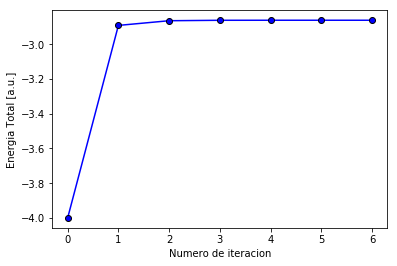

In [250]:
# plt.plot(Eks,'ro-',mec='k',label='KS')
# plt.plot(EHartree,'mo-',mec='k',label='Hartree')
# plt.plot(Ex,'bo-',mec='k',label='Exchange')
plt.plot(Etot, 'bo-', mec='k',label='Total')
plt.xlabel('Numero de iteracion')
plt.ylabel("Energia Total [a.u.]")
#plt.legend(loc='best')


- Puedo ver que estoy un poco alejado de la energia exacta ($E_{exacta} = 2.091 a.u.$), y yo obtengo $E = 2.861 a.u.$, voy a empezar a agregar correcciones a ver si mejora

# Agrego ahora el exchange

### Inicializo las variables para el loop

In [251]:
# inicialmente
N = 1200 # cantidad de puntos
Z = 2
l = 0
h = 0.007 # resolucion espacial

H, r = H_matriz(h,N,Z,l)
Etot = []
EHartree = []
Ex = []
Eks = []
print r[-1]
u = np.zeros(N)
it = 0 # contador de iteraciones

8.4


### Aca inicia el loop
### Calculo los potenciales

In [268]:
# Calculo el potencial de Hartree
F = -u**2/r
VHartree = 2*verlet(h,F,N,r)/r
EHartree.append(np.trapz(VHartree*u**2,r))

# Calculo el potencial de exchange
Vx = -((3*u**2)/(2*np.pi**2*r**2))**(1/3)
Ex.append(np.trapz(Vx*u**2,r))

H = H_matriz(h,N,Z,l)[0] + np.diag(VHartree+Vx)

### Calculo las energias de los orbitales de KS

In [269]:
# E son las energias, v las respectivas funciones de onda 
# sin normalizar como columnas de una matriz v de autovectores
E, psis = eigh(H)
print E[:10]

[-0.53885275  0.07121715  0.33936044  0.7745039   1.36174887  2.0957492
  2.97408105  3.9954422   5.15903909  6.46434181]


### Elijo con el indice j con que autovalor y autovector me quedo de los que obtuve mediante la diagonalizacion, y normalizo la funcion de onda

In [270]:
j = 0
Eks.append(E[j])
norm = np.trapz(psis[:,j]**2,r)
u = psis[:,j]/norm**0.5

### Calculo la energia total

In [271]:
Etot.append(2*Eks[-1] - EHartree[-1] - 0.5*Ex[-1])
it += 1
for i in range(it):
    print "Iteracion ",i, ":"
    print "\t*) Energia Total:", Etot[i]
    print "\t*) Energia Kohn-Sham:", Eks[i]
    print "\t*) Correccion de Hartree", EHartree[i]
    print "\t*) Correccion de Exchange", Ex[i]


Iteracion  0 :
	*) Energia Total: -3.9998040191807314
	*) Energia Kohn-Sham: -1.9999020095903657
	*) Correccion de Hartree 0.0
	*) Correccion de Exchange 0.0
Iteracion  1 :
	*) Energia Total: -2.7844679710416878
	*) Energia Kohn-Sham: -0.3209406777317491
	*) Correccion de Hartree 2.4999563354506242
	*) Correccion de Exchange -0.7147394397448696
Iteracion  2 :
	*) Energia Total: -2.7389425713047135
	*) Energia Kohn-Sham: -0.6280636765687111
	*) Correccion de Hartree 1.7333134360480742
	*) Correccion de Exchange -0.5009964357615663
Iteracion  3 :
	*) Energia Total: -2.7264106404059034
	*) Energia Kohn-Sham: -0.4714920653312456
	*) Correccion de Hartree 2.0829179164844396
	*) Correccion de Exchange -0.5989828134820546
Iteracion  4 :
	*) Energia Total: -2.7241142367439277
	*) Energia Kohn-Sham: -0.5388527533187168
	*) Correccion de Hartree 1.9236132620556543
	*) Correccion de Exchange -0.5544090638983206


Text(0,0.5,u'Energia Total [a.u.]')

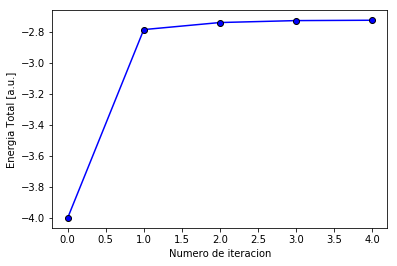

In [272]:
# plt.plot(Eks,'ro-',mec='k',label='KS')
# plt.plot(EHartree,'mo-',mec='k',label='Hartree')
# plt.plot(Ex,'bo-',mec='k',label='Exchange')
plt.plot(Etot, 'bo-', mec='k',label='Total')
plt.xlabel('Numero de iteracion')
plt.ylabel("Energia Total [a.u.]")
#plt.legend(loc='best')


- Me aleje aun mas de la energia exacta, yo obtengo $E = 2.724 a.u.$ ahora, esto es debido a que estoy agregando exchange con 2 electrones. Voy a agregar una correccion mas de correlacion a ver si mejora

# Agrego ahora la correlacion de Ceperley-Alder

### Inicializo las variables para el loop

In [273]:
# inicialmente
N = 1200 # cantidad de puntos
Z = 2
l = 0
h = 0.007 # resolucion espacial

H, r = H_matriz(h,N,Z,l)
Etot = []
EHartree = []
Ex = []
Eks = []
Ec = []
print r[-1]
u = np.zeros(N)
it = 0 # contador de iteraciones

8.4


### Aca inicia el loop
### Calculo los potenciales

In [299]:
# Calculo el potencial de Hartree
F = -u**2/r
VHartree = 2*verlet(h,F,N,r)/r
EHartree.append(np.trapz(VHartree*u**2,r))

# Calculo el potencial de exchange
Vx = -((3*u**2)/(2*np.pi**2*r**2))**(1/3)
Ex.append(np.trapz(Vx*u**2,r))

# Calculo la correlacion de Ceperley-Alder
if it > 0: # para la primer iteracion, lo hago nulo
    CCA = Corr_Cep_Ald(u,r)
    Ec.append(CCA[0])
    Vc = CCA[1]
else:
    Vc = np.zeros(N)
    Ec.append(0)

H = H_matriz(h,N,Z,l)[0] + np.diag(VHartree+Vx+Vc)

### Calculo las energias de los orbitales de KS

In [300]:
# E son las energias, v las respectivas funciones de onda 
# sin normalizar como columnas de una matriz v de autovectores
E, psis = eigh(H)
print E[:10]

[-0.57085365  0.06352495  0.32955219  0.76372118  1.35041134  2.08408338
  2.9622124   3.98344266  5.14695026  6.45218705]


### Elijo con el indice j con que autovalor y autovector me quedo de los que obtuve mediante la diagonalizacion, y normalizo la funcion de onda

In [301]:
j = 0
Eks.append(E[j])
norm = np.trapz(psis[:,j]**2,r)
u = psis[:,j]/norm**0.5

### Calculo la energia total

In [302]:
Etot.append(2*Eks[-1] - EHartree[-1] - 0.5*Ex[-1] + Ec[-1])
it += 1
for i in range(it):
    print "Iteracion ",i, ":"
    print "\t*) Energia Total:", Etot[i]
    print "\t*) Energia Kohn-Sham:", Eks[i]
    print "\t*) Correccion de Hartree", EHartree[i]
    print "\t*) Correccion de Exchange", Ex[i]
    print "\t*) Correccion de Ceperley-Alder", Ec[i]


Iteracion  0 :
	*) Energia Total: -3.9998040191807314
	*) Energia Kohn-Sham: -1.9999020095903657
	*) Correccion de Hartree 0.0
	*) Correccion de Exchange 0.0
	*) Correccion de Ceperley-Alder 0
Iteracion  1 :
	*) Energia Total: -2.9898717371400783
	*) Energia Kohn-Sham: -0.3778713498212417
	*) Correccion de Hartree 2.4999563354506242
	*) Correccion de Exchange -0.7147394397448696
	*) Correccion de Ceperley-Alder -0.09154242191940531
Iteracion  2 :
	*) Energia Total: -2.8913492965418928
	*) Energia Kohn-Sham: -0.6635526758767324
	*) Correccion de Hartree 1.7864094047600854
	*) Correccion de Exchange -0.5155823116265174
	*) Correccion de Ceperley-Alder -0.03562569584160173
Iteracion  3 :
	*) Energia Total: -2.9029733625481757
	*) Energia Kohn-Sham: -0.5300322388571702
	*) Correccion de Hartree 2.086970312210529
	*) Correccion de Exchange -0.6000187308176569
	*) Correccion de Ceperley-Alder -0.0559479380321347
Iteracion  4 :
	*) Energia Total: -2.8917941170932737
	*) Energia Kohn-Sham: -0.

Text(0,0.5,u'Energia Total [a.u.]')

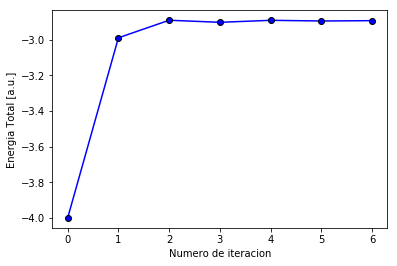

In [303]:
# plt.plot(Eks,'ro-',mec='k',label='KS')
# plt.plot(EHartree,'mo-',mec='k',label='Hartree')
# plt.plot(Ex,'bo-',mec='k',label='Exchange')
plt.plot(Etot, 'bo-', mec='k',label='Total')
plt.xlabel('Numero de iteracion')
plt.ylabel("Energia Total [a.u.]")
#plt.legend(loc='best')


- Evidentemente el resultado ahora es mucho mejor $E = 2.894$, aunque todavia estoy teniendo una diferencia de $0.01 a.u.$ con respecto a la solucion exacta. Yo creo que esto podria mejorar bastante teniendo un mejor metodo para hallar los orbitales de Kohn-Sham, ya sea diagonilizando con mas puntos o haciendo Numerov con predictor-corrector.

# Pseudo Potencial

In [ ]:
r, v3s = np.loadtxt("Na_wave.3s",unpack = True)
plt.plot(r,v3s,'ro-',mec='k')
plt.xlim([0,8])

idxMax = np.where(v3s == np.max(v3s))
rMax = r[idxMax]
plt.plot(rMax,v3s[idxMax],'go')

In [ ]:
x = np.arange(0.001,10,0.001)
plt.plot(x,np.log(x))